In [102]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch
import yaml

from models import MultiStage_VAE
from utils import get_dataloader
import yaml

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\yanne\anaconda3\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [125]:
BS = 256
dataset = torchvision.datasets.MNIST(root = '.',download = False, transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()]))
#Important no Normalize since we want image between 0, 1 to get the targets as int [0, ..., 255]
dataloader = DataLoader(dataset,batch_size=BS, shuffle=True)

In [128]:
with open('./multistage_vae_params.yaml', 'rb') as f:
    config = yaml.safe_load(f)

size_second_stage = 3
model = MultiStage_VAE(config['model parameters'], size_second_stage)
model.to(device)

MultiStage_VAE(
  (vae): VAE_complex(
    (init_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (encoder_blocks): ModuleList(
      (0): VAE_Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, 

In [105]:
x = next(iter(dataloader))[0]

In [106]:
out, x_first, mu, logvar = model(x.to(device))

In [107]:
out.shape, x_first.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 1, 28, 28]))

In [108]:
model.vae.decoder_output_pad

[0, 1, 1]

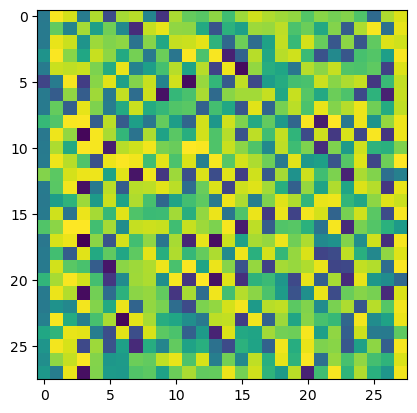

In [109]:
imshow(out.detach().cpu()[0].permute(1,2,0).numpy())

In [110]:

def loss_function(x, x_final, x_pred, mu, logvar, kl_weight):
    loss_mse = F.mse_loss(x, x_pred)
    loss_kl = torch.mean(0.5 * torch.sum(1-mu**2 - logvar.exp() +logvar, dim = 1), dim = 0)
    loss_l1 = F.l1_loss(x, x_final)
    loss = loss_mse - kl_weight * loss_kl + loss_l1
    
    return loss, loss_mse.item(), -loss_kl.item(), loss_l1.item()

In [111]:
lr = 1e-3
kl_weight = 1
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

In [132]:
losses = []
losses_mse = []
losses_l1 = []


epochs = 50
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for x, _ in pbar:
        x = x.to(device)
        optimizer.zero_grad()

        out, x_first, mu, logvar = model(x)

        loss, loss_mse, loss_kl, loss_l1 = loss_function(x, out, x_first, mu, logvar, kl_weight)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        losses_mse.append(loss_mse)
        losses_l1.append(loss_l1)
        pbar.set_description('Loss: %.3f, loss MSE: %.3f, loss L1: %.3f' % (loss.item(),loss_mse, loss_l1 ))

    

Loss: 11.195, loss MSE: 0.037, loss L1: 0.073:  35%|███▍      | 82/235 [00:05<00:09, 15.80it/s]


KeyboardInterrupt: 

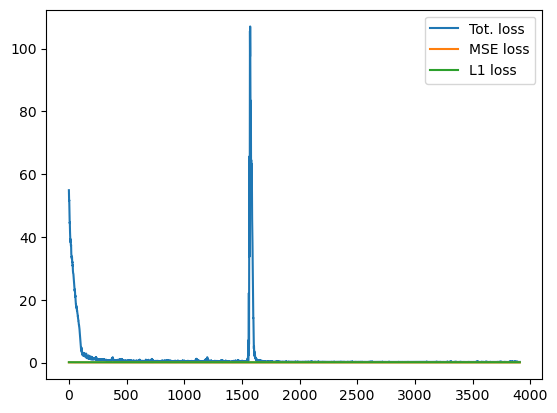

In [119]:
plot(losses[100:], label = 'Tot. loss')
plot(losses_mse[100:], label = 'MSE loss')
plot(losses_l1[100:], label = 'L1 loss')
legend()

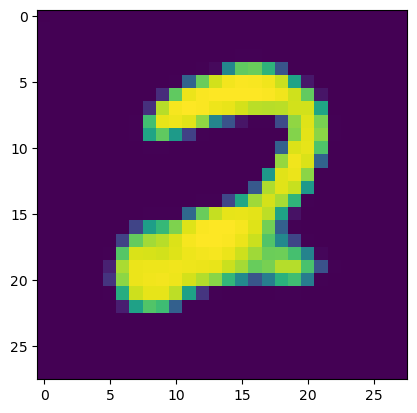

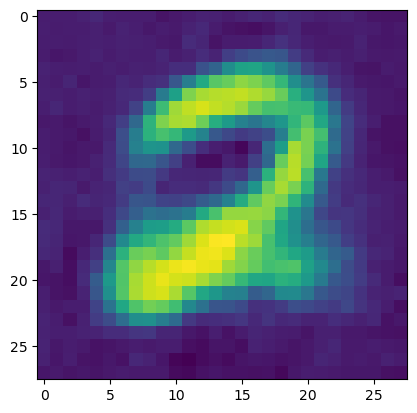

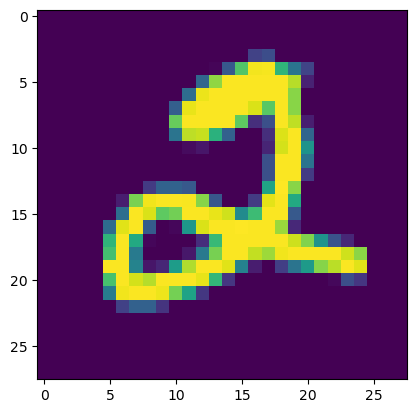

In [133]:
imshow(out[0].detach().cpu().permute(1,2,0).numpy())
show()
imshow(x_first[0].detach().cpu().permute(1,2,0).numpy())
show()
imshow(x[0].detach().cpu().permute(1,2,0).numpy())

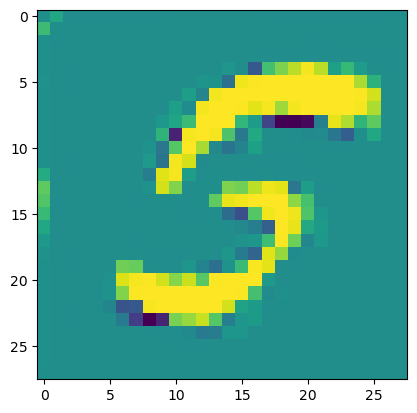

In [151]:
x_samp = model.sample(1)
imshow(x_samp[0].cpu().permute(1,2,0).numpy())

In [129]:
#torch.save(model.state_dict(), './model_saves/multistageVAE_MNIST.pth')
#model.load_state_dict(torch.load('./model_saves/multistageVAE_MNIST.pth'))

<All keys matched successfully>

#### We see the second part makes output far less blurry, regarding the sampling, it leads to sub optimal outputs

It should be more interesting on AFHQ dataset.